In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- SETUP ---
sns.set_style(style="whitegrid")

# Make sure project root is added so "src" is importable
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import from the src package
from src.sentiment_thematic_analysis import BankReviewPipeline

c:\Users\amare\Documents\KAIM\week-2\customer-experience-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading DistilBERT Sentiment Model...


Device set to use cpu


In [2]:
analyzer = BankReviewPipeline()
df = analyzer.run()



--- Starting Bank Review NLP Pipeline ---
Loading data from c:\Users\amare\Documents\KAIM\week-2\customer-experience-analytics\data/processed/reviews_processed.csv...
✅ Loaded 1399 reviews.
Running all three Sentiment Models...
-> Running VADER...


100%|██████████| 1399/1399 [00:00<00:00, 13825.01it/s]


-> Running TextBlob...


100%|██████████| 1399/1399 [00:00<00:00, 2845.28it/s]


-> Running DistilBERT...


100%|██████████| 1399/1399 [00:42<00:00, 33.13it/s]


✅ Sentiment Analysis complete.

--- Aggregated Sentiment (Mean Score) ---
                      bank_name  rating  vader_score  textblob_score  \
0             Bank of Abyssinia       1    -0.180938       -0.118847   
1             Bank of Abyssinia       2     0.115493        0.142372   
2             Bank of Abyssinia       3     0.182274        0.188075   
3             Bank of Abyssinia       4     0.351581        0.288581   
4             Bank of Abyssinia       5     0.368012        0.470727   
5   Commercial Bank of Ethiopia       1    -0.087437       -0.086855   
6   Commercial Bank of Ethiopia       2     0.084570        0.132761   
7   Commercial Bank of Ethiopia       3     0.168980        0.167102   
8   Commercial Bank of Ethiopia       4     0.330806        0.307036   
9   Commercial Bank of Ethiopia       5     0.395935        0.491520   
10                  Dashen Bank       1    -0.125086       -0.142068   
11                  Dashen Bank       2     0.023394        0.

100%|██████████| 1399/1399 [00:16<00:00, 82.71it/s] 


Calculating TF-IDF scores...


100%|██████████| 1399/1399 [00:00<00:00, 41506.32it/s]

✅ Theme assignment complete.

✅ Saved FINAL results to c:\Users\amare\Documents\KAIM\week-2\customer-experience-analytics\data/processed/reviews_with_sentiment.csv

--- Theme Distribution ---
identified_theme
General / Unspecified                                                         820
Mobile App & Digital                                                          424
Transactions & Fees                                                            51
Customer Service                                                               22
Mobile App & Digital, Transactions & Fees                                      22
Customer Service, Mobile App & Digital                                         14
Security & Fraud                                                                9
Cards & Accounts, Security & Fraud                                              9
Cards & Accounts, Mobile App & Digital, Security & Fraud                        7
Cards & Accounts                                     

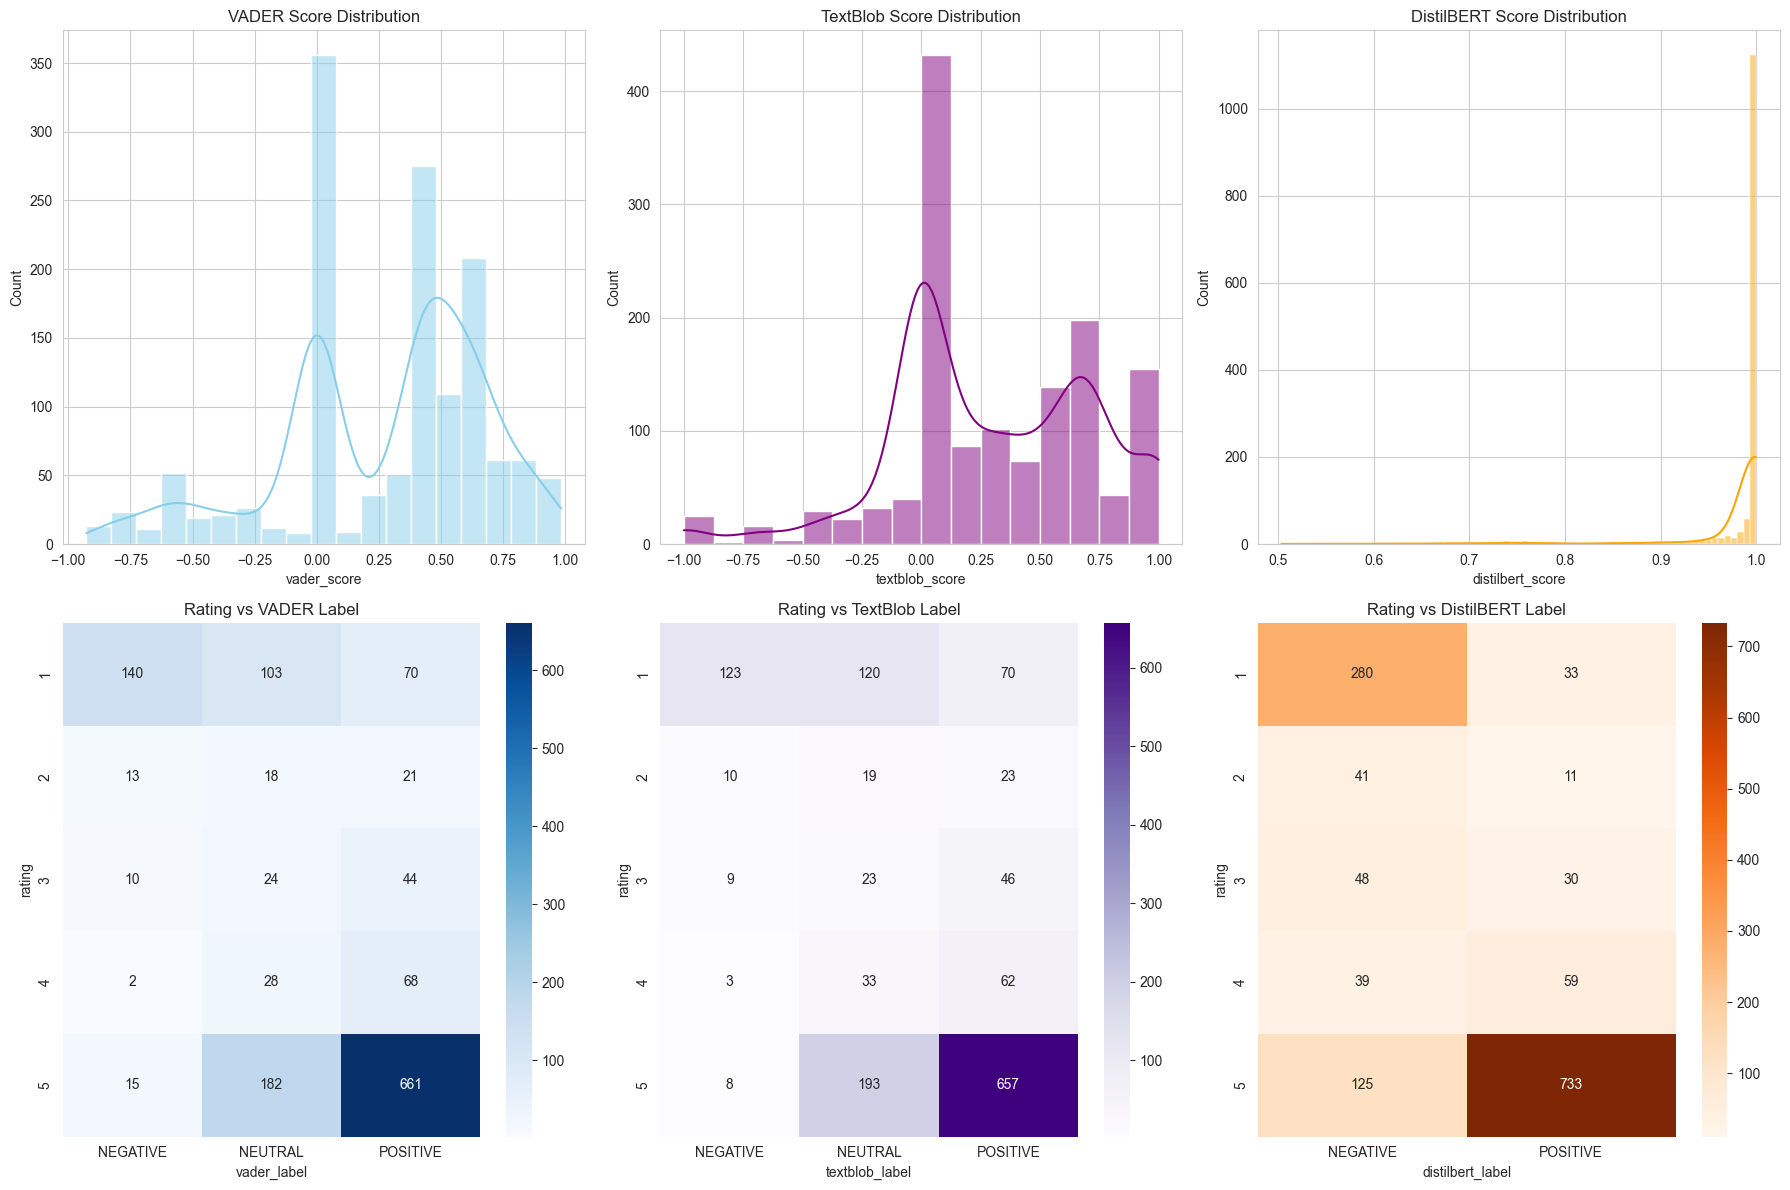

In [8]:
# -------------------------------
# 1. Model Diagnostics (including DistilBERT)
# -------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ensure columns exist
for col in ["vader_score", "textblob_score", "distilbert_score",
            "vader_label", "textblob_label", "distilbert_label", "rating"]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in df")

# VADER histogram
sns.histplot(df["vader_score"], kde=True, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("VADER Score Distribution")

# TextBlob histogram
sns.histplot(df["textblob_score"], kde=True, color="purple", ax=axes[0,1])
axes[0,1].set_title("TextBlob Score Distribution")

# DistilBERT histogram
sns.histplot(df["distilbert_score"], kde=True, color="orange", ax=axes[0,2])
axes[0,2].set_title("DistilBERT Score Distribution")

# Heatmaps for labels
sns.heatmap(pd.crosstab(df["rating"], df["vader_label"]), annot=True, fmt="d", cmap="Blues", ax=axes[1,0])
axes[1,0].set_title("Rating vs VADER Label")

sns.heatmap(pd.crosstab(df["rating"], df["textblob_label"]), annot=True, fmt="d", cmap="Purples", ax=axes[1,1])
axes[1,1].set_title("Rating vs TextBlob Label")

sns.heatmap(pd.crosstab(df["rating"], df["distilbert_label"]), annot=True, fmt="d", cmap="Oranges", ax=axes[1,2])
axes[1,2].set_title("Rating vs DistilBERT Label")


plt.tight_layout()
plt.show()


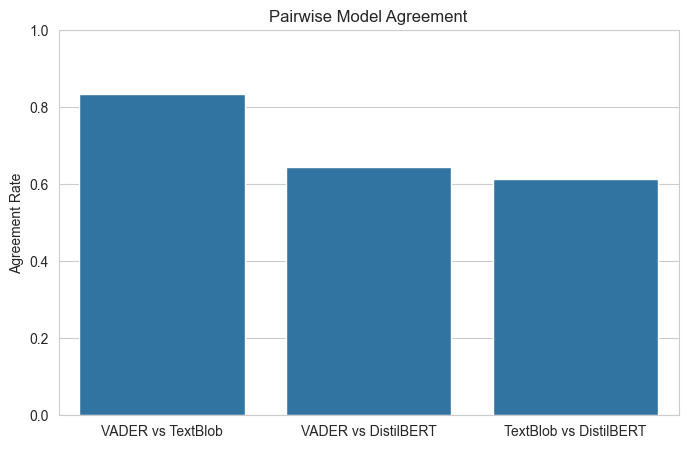

In [10]:
# Compute agreement between pairs
df["agree_vader_textblob"] = df["vader_label"] == df["textblob_label"]
df["agree_vader_distilbert"] = df["vader_label"] == df["distilbert_label"]
df["agree_textblob_distilbert"] = df["textblob_label"] == df["distilbert_label"]

# Prepare agreement info
agreements = {
    "VADER vs TextBlob": df["agree_vader_textblob"].mean(),
    "VADER vs DistilBERT": df["agree_vader_distilbert"].mean(),
    "TextBlob vs DistilBERT": df["agree_textblob_distilbert"].mean(),
}

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=list(agreements.keys()), y=list(agreements.values()) )
plt.ylim(0,1)
plt.ylabel("Agreement Rate")
plt.title("Pairwise Model Agreement")
plt.show()


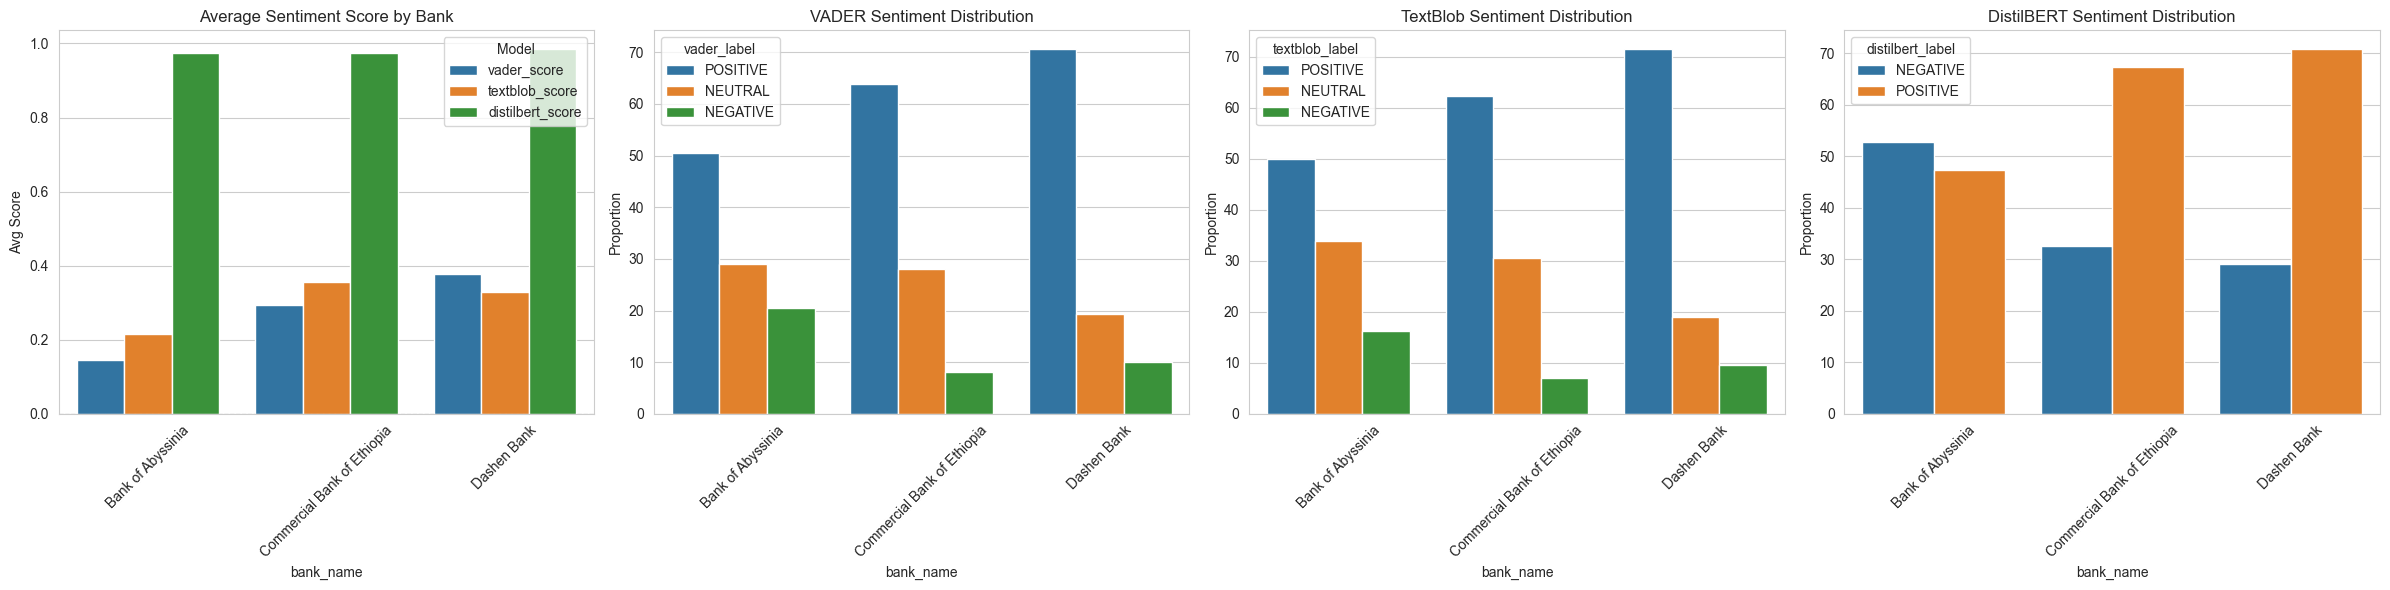

In [11]:
# -------------------------------
# 2. Bank Sentiment (including DistilBERT)
# -------------------------------
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Added DistilBERT plot

# 1️⃣ Average score per bank (all 3 models)
bank_avg = df.groupby("bank_name")[["vader_score", "textblob_score", "distilbert_score"]].mean().reset_index()
bank_melt = bank_avg.melt(id_vars="bank_name", var_name="Model", value_name="Avg Score")
sns.barplot(x="bank_name", y="Avg Score", hue="Model", data=bank_melt, ax=axes[0])
axes[0].set_title("Average Sentiment Score by Bank")
axes[0].axhline(0, color="gray", linestyle="--", linewidth=0.8)
axes[0].tick_params(axis='x', rotation=45)

# 2️⃣ VADER sentiment proportions
vader_props = df.groupby("bank_name")["vader_label"].value_counts(normalize=True).mul(100).rename("Proportion").reset_index()
sns.barplot(x="bank_name", y="Proportion", hue="vader_label", data=vader_props, ax=axes[1])
axes[1].set_title("VADER Sentiment Distribution")
axes[1].tick_params(axis='x', rotation=45)

# 3️⃣ TextBlob sentiment proportions
tb_props = df.groupby("bank_name")["textblob_label"].value_counts(normalize=True).mul(100).rename("Proportion").reset_index()
sns.barplot(x="bank_name", y="Proportion", hue="textblob_label", data=tb_props, ax=axes[2])
axes[2].set_title("TextBlob Sentiment Distribution")
axes[2].tick_params(axis='x', rotation=45)

# 4️⃣ DistilBERT sentiment proportions
db_props = df.groupby("bank_name")["distilbert_label"].value_counts(normalize=True).mul(100).rename("Proportion").reset_index()
sns.barplot(x="bank_name", y="Proportion", hue="distilbert_label", data=db_props, ax=axes[3])
axes[3].set_title("DistilBERT Sentiment Distribution")
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




C:\Users\amare\AppData\Local\Temp\ipykernel_14288\1664929472.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.values, y=theme_counts.index, palette="viridis")
C:\Users\amare\AppData\Local\Temp\ipykernel_14288\1664929472.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_avg_rating.values, y=theme_avg_rating.index, palette="magma")


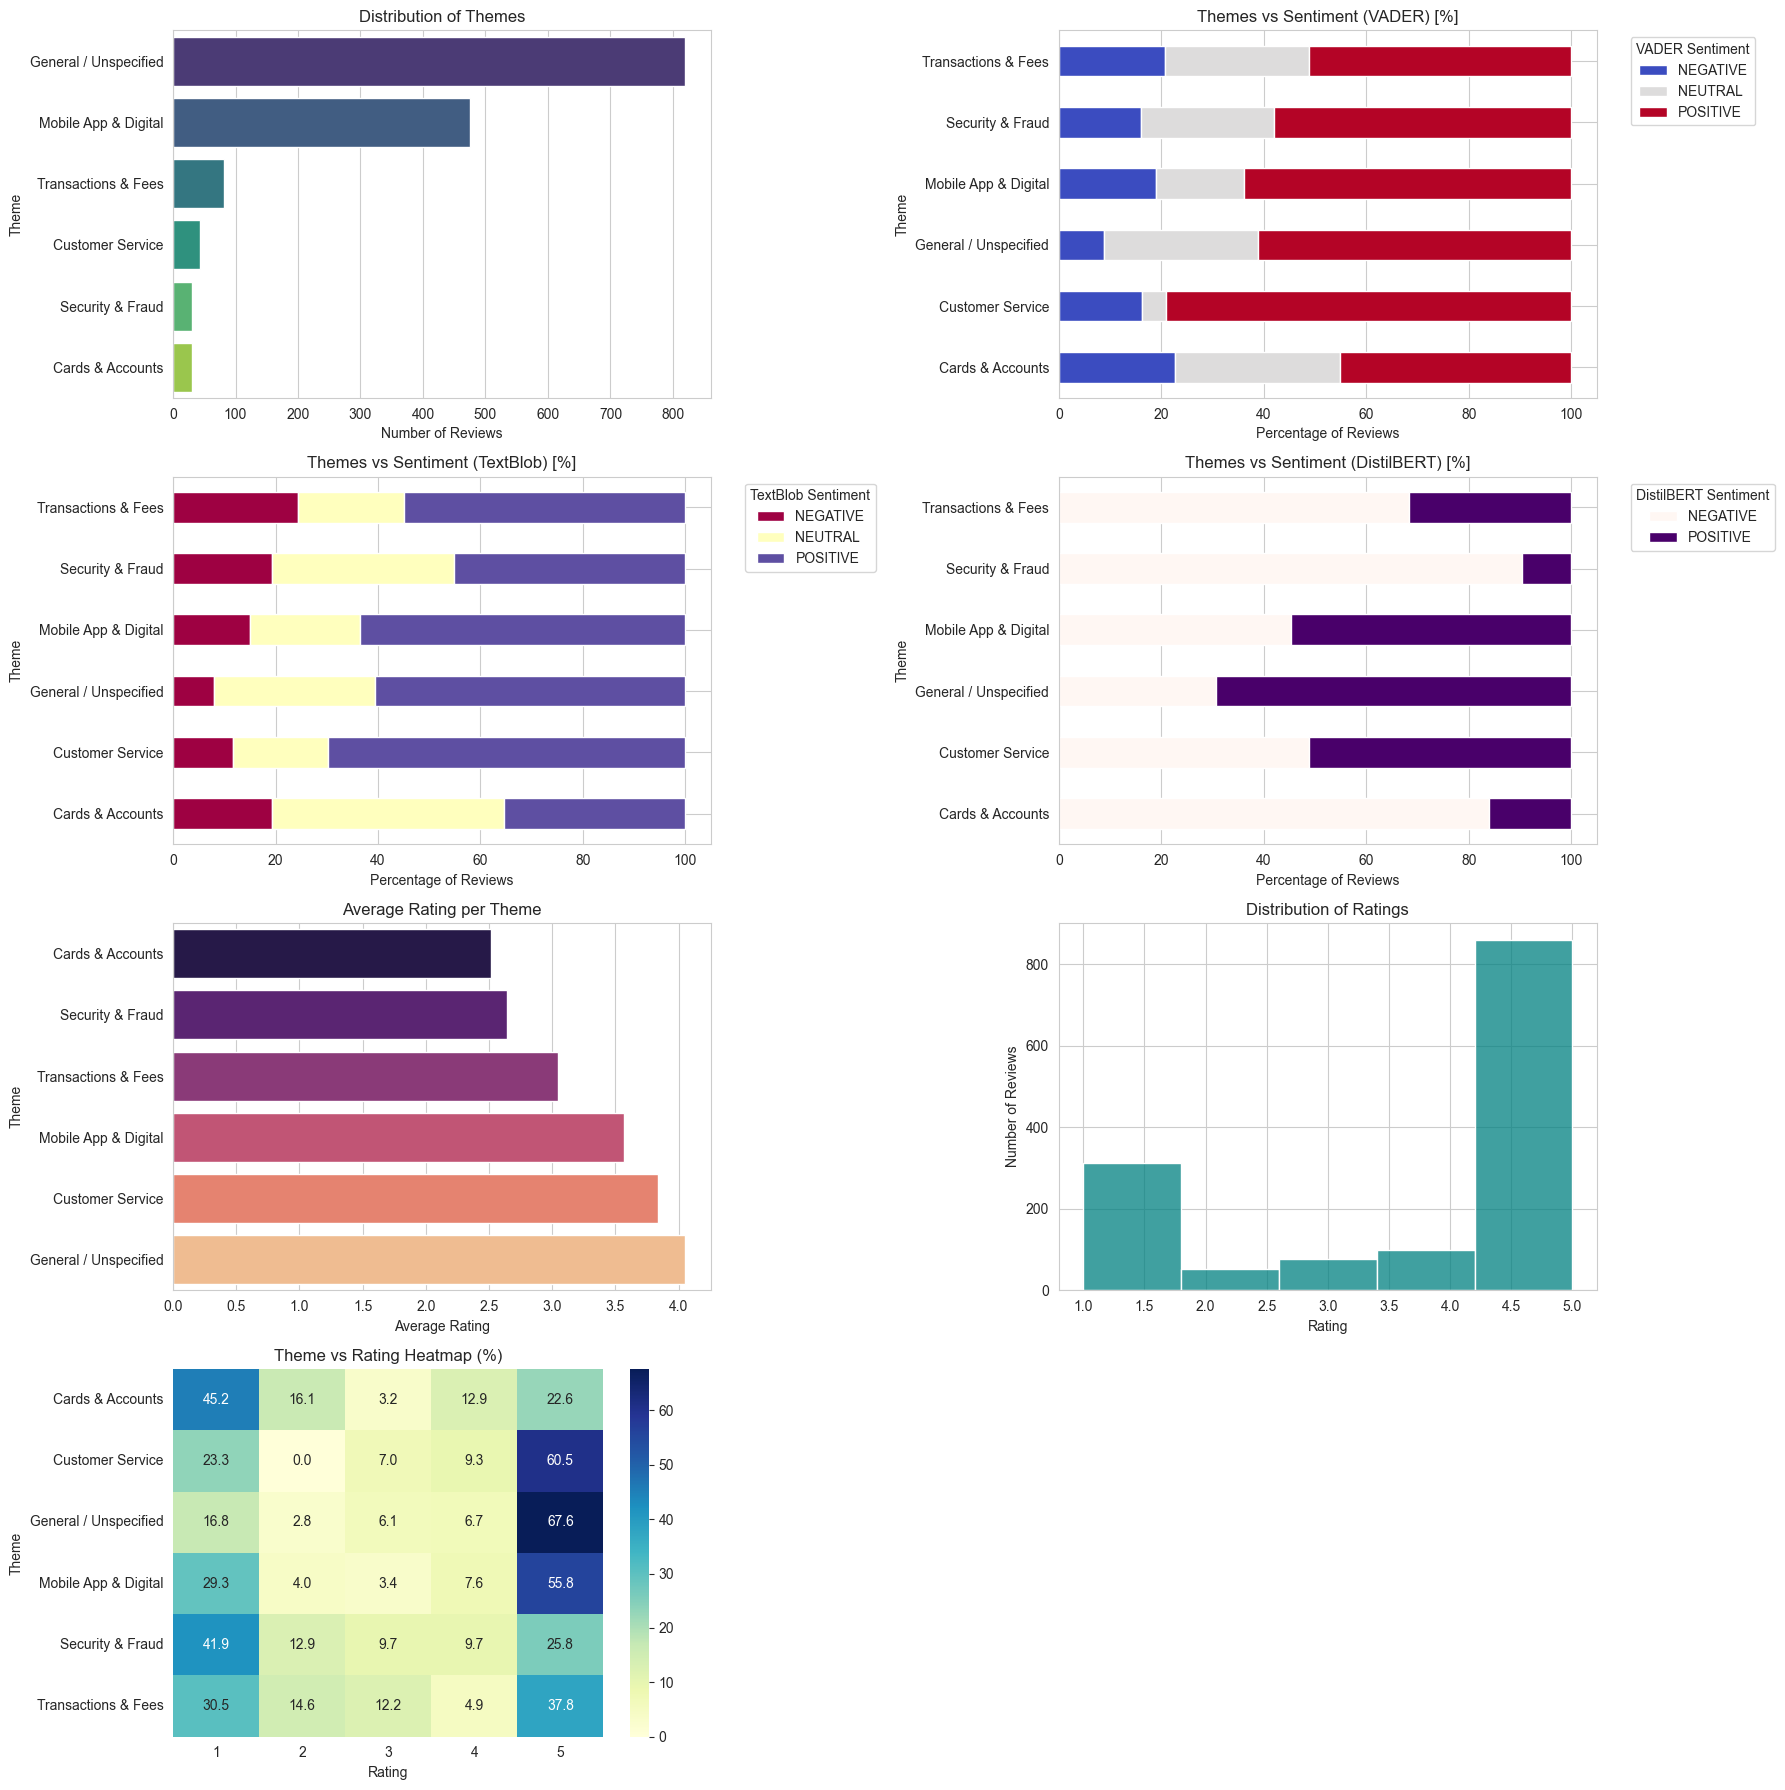

In [13]:
# Split multi-themes into separate rows for better plotting
df_expanded = df.copy()
df_expanded = df_expanded.assign(identified_theme=df_expanded['identified_theme'].str.split(', ')).explode('identified_theme')

plt.figure(figsize=(18, 18))

# ---------------------------
# 1. Theme Distribution (Count)
# ---------------------------
plt.subplot(4, 2, 1)
theme_counts = df_expanded['identified_theme'].value_counts()
sns.barplot(x=theme_counts.values, y=theme_counts.index, palette="viridis")
plt.title("Distribution of Themes")
plt.xlabel("Number of Reviews")
plt.ylabel("Theme")

# ---------------------------
# 2. Theme vs Sentiment (VADER) - Stacked
# ---------------------------
plt.subplot(4, 2, 2)
vader_props = df_expanded.groupby(['identified_theme', 'vader_label']).size().unstack(fill_value=0)
vader_props_pct = vader_props.div(vader_props.sum(axis=1), axis=0) * 100
vader_props_pct.plot(kind='barh', stacked=True, ax=plt.gca(), colormap="coolwarm")
plt.title("Themes vs Sentiment (VADER) [%]")
plt.xlabel("Percentage of Reviews")
plt.ylabel("Theme")
plt.legend(title="VADER Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------------------------
# 3. Theme vs Sentiment (TextBlob) - Stacked
# ---------------------------
plt.subplot(4, 2, 3)
tb_props = df_expanded.groupby(['identified_theme', 'textblob_label']).size().unstack(fill_value=0)
tb_props_pct = tb_props.div(tb_props.sum(axis=1), axis=0) * 100
tb_props_pct.plot(kind='barh', stacked=True, ax=plt.gca(), colormap="Spectral")
plt.title("Themes vs Sentiment (TextBlob) [%]")
plt.xlabel("Percentage of Reviews")
plt.ylabel("Theme")
plt.legend(title="TextBlob Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------------------------
# 4. Theme vs Sentiment (DistilBERT) - Stacked NEW
# ---------------------------
plt.subplot(4, 2, 4)
bert_props = df_expanded.groupby(['identified_theme', 'distilbert_label']).size().unstack(fill_value=0)
bert_props_pct = bert_props.div(bert_props.sum(axis=1), axis=0) * 100
bert_props_pct.plot(kind='barh', stacked=True, ax=plt.gca(), colormap="RdPu")
plt.title("Themes vs Sentiment (DistilBERT) [%]")
plt.xlabel("Percentage of Reviews")
plt.ylabel("Theme")
plt.legend(title="DistilBERT Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------------------------
# 5. Average Rating per Theme
# ---------------------------
plt.subplot(4, 2, 5)
theme_avg_rating = df_expanded.groupby("identified_theme")["rating"].mean().sort_values()
sns.barplot(x=theme_avg_rating.values, y=theme_avg_rating.index, palette="magma")
plt.title("Average Rating per Theme")
plt.xlabel("Average Rating")
plt.ylabel("Theme")

# ---------------------------
# 6. Rating Distribution
# ---------------------------
plt.subplot(4, 2, 6)
sns.histplot(df['rating'], bins=5, kde=False, color="teal")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")

# ---------------------------
# 7. Theme vs Rating Heatmap (Percent)
# ---------------------------
plt.subplot(4, 2, 7)
theme_rating_matrix = pd.crosstab(df_expanded['identified_theme'], df_expanded['rating'])
theme_rating_matrix_pct = theme_rating_matrix.div(theme_rating_matrix.sum(axis=1), axis=0) * 100
sns.heatmap(theme_rating_matrix_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Theme vs Rating Heatmap (%)")
plt.xlabel("Rating")
plt.ylabel("Theme")

plt.tight_layout()
plt.show()
